# Data Processing
## Purpose
State the purpose of the notebook.
## Methodology
Quickly describle assumptions and processing steps.
## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:

- Todo 1;
- Todo 2;

## Results
Describe and comment the most important results.

# Setup
## Library import
We import all the required Python libraries

In [405]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import regionmask
import cartopy.crs as ccrs
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Utils

**set_lat_lon_attrs**

In [2]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

**create_ds_mask**

In [3]:
def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    """Create masks of geographical regions"""
    # Create index column
    if 'index' not in df:
        df = df.reset_index(drop=True).reset_index()

    # Extract indexes and geoms that are large enough!
    id_ints = df['index'].values
    geoms = df['geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')


    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # get the ints not written to mask
    id_ints_not_in_mask = df[~df['index'].isin(id_ints_mask)]['index'].values
    
    if len(id_ints_not_in_mask) > 0: 
        print(f'Ints not in mask: {id_ints_not_in_mask}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    
    return da_mask, id_ints_not_in_mask

**number_of_digits**

In [305]:
def number_of_digits(x):
    """Get number of digits to the left/right of a decimal point"""
    # Number of digits to the left of the decimal point
    dig_left = int(np.log10(x))+1
    # Number of digits to the right of the decimal point
    if '.' in str(x):
        decList = [int(y) for y in list(str(x).split('.')[1])]
        dig_right = next((i for i, x in enumerate(decList) if x), None) + 1
    else:
        dig_right = 0
        
    return dig_left, dig_right

**find_nearest**

In [490]:
def find_nearest(array, value):
    """Find nearest value in numpy array"""
    array = np.asarray(array)
    
    # Get the mean step values
    step = np.abs(np.diff(array)).max()*1.5
    
    # Find the nearest values
    diff = np.abs(array - value)
    idx = np.argwhere((diff >= np.amin(diff) - step) & (diff <= np.amin(diff) + step))

    return idx

**get_xy_from_latlon**

In [512]:
def get_nearest_xy_from_latlon(ds, lat, lon, lon_name='lon', lat_name='lat'):
    """Return the x/y values for a given longitude/latitude values"""
    # Read all lon/lat values
    lons = ds[lon_name].data
    lats = ds[lat_name].data
    
    # Get mean lon/lat step size 
    mean_lat_size = np.abs(np.diff(lats)).mean()
    #print(mean_y_size)
    mean_lon_size = np.abs(np.diff(lons)).mean()
    
    # Round lon/lat values to the first decimal place
    dig_left, dig_right = number_of_digits(mean_lat_size) 
    if dig_right == 0: 
        lat = round(lat)
    else:
        lat = round(lat, dig_right)
        
    dig_left, dig_right = number_of_digits(mean_lon_size) 
    if dig_right == 0: 
        lon = round(lon)
    else:
        lon = round(lon, dig_right)
    
    # Find the positions of the nearest longitude/latitude values
    idx_lon = find_nearest(lons, lon)
    idx_lat = find_nearest(lats, lat)
    
    # Check the identical rows in both arrays
    res = (idx_lon[:, None] == idx_lat).all(-1).any(-1)
    yx_positions = idx_lon[res]
    
    
    if yx_positions.shape[0] == 0:
        raise Exception("Sorry, lat/lon values outside data domain")   
    if yx_positions.shape[0] > 1:
        # If more than one identical rows take the row nearest to the mean value
        yx_positions = np.mean(yx_positions,axis=0).astype(int).reshape(1,2)

    # Get the x/y values
    x_position = yx_positions[0][1]
    y_position = yx_positions[0][0]
    
    x = ds.rlon.data[yx_positions[0][1]]
    y = ds.rlat.data[yx_positions[0][0]]

    return x_position, y_position, x, y

**get_nearest_latlon_from_latlon**

In [513]:
def get_nearest_latlon_from_latlon(ds, lat, lon, lon_name='lon', lat_name='lat'):
    """Return the x/y values for a given longitude/latitude values"""
    # Read all lon/lat values
    lons = ds[lon_name].data
    lats = ds[lat_name].data
    
    # Get mean lon/lat step size 
    mean_lat_size = np.abs(np.diff(lats)).mean()
    #print(mean_y_size)
    mean_lon_size = np.abs(np.diff(lons)).mean()
    
    # Round lon/lat values to the first decimal place
    dig_left, dig_right = number_of_digits(mean_lat_size) 
    if dig_right == 0: 
        lat = round(lat)
    else:
        lat = round(lat, dig_right)
        
    dig_left, dig_right = number_of_digits(mean_lon_size) 
    if dig_right == 0: 
        lon = round(lon)
    else:
        lon = round(lon, dig_right)
    
    # Find the positions of the nearest longitude/latitude values
    lon_positions = find_nearest(lons, lon)
    lat_positions = find_nearest(lats, lat)
    
    # If more than one identical rows take the row nearest to the mean value
    lon_position = round(np.mean(lon_positions))
    lat_position = round(np.mean(lat_positions))

    return lon_position, lat_position

**rasterize_vector_dat**

In [429]:
def rasterize_vector_data(gdf, ds, name='mask', logical_coordinates=False, lon_name='lon', lat_name='lat'):
    #Create the data mask by rasterizing the vector data
    gdf = gdf.reset_index(drop=True)
    da_mask, id_ints_not_in_mask = create_ds_mask(gdf, ds, name='mask', lon_name=lon_name, lat_name=lat_name)
    
    #Add geometries smaller than mean cell size into the mask
    print("Adding geometries smaller than mean cell size into the mask:")
    gdf_not_in_mask = gdf.iloc[id_ints_not_in_mask].copy()
    
    gdf_not_in_mask['centroid'] = gdf_not_in_mask['geometry'].apply(lambda x: x.centroid)
    
    for id_int in tqdm(id_ints_not_in_mask):
        lon = gdf_not_in_mask['centroid'].loc[id_int].x
        lat = gdf_not_in_mask['centroid'].loc[id_int].y
        
        if logical_coordinates:
            # Get x/y positions for the corresponding longitude/latitude values
            x_pos, y_pos, x, y = get_nearest_xy_from_latlon(ds, lat, lon, lon_name=lon_name, lat_name=lat_name)
        else:
            # Get longitude/latitude positions for the corresponding longitude/latitude values
            x_pos, y_pos = get_nearest_latlon_from_latlon(ds, lat, lon, lon_name=lon_name, lat_name=lat_name)
        
        # Replace cell value with new int
        da_mask.data[y_pos, x_pos] = id_int
        
    # update da attributes
    da_mask.attrs['id_ints'] = list(gdf.index)
    
    return da_mask

# Data import

## Fenómenos climáticos extremos (raster)
- ### Fire danger indicators
    **[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview)**

    The dataset presents projections of fire danger indicators for Europe based upon the Canadian Fire Weather Index System (FWI) under future climate conditions. The FWI is a meteorologically based index used worldwide to estimate the fire danger and is implemented in the Global ECMWF Fire Forecasting model (GEFF).

    **Variables:**
    - **Seasonal fire weather index:** 
    The mean fire weather index value over the European fire season (June-September). This is calculated as the sum of the daily fire weather index over the European fire season divided by the total number of days within this date range. The higher the index value, the more favorable the meteorological conditions to trigger a wildfire are.
    
- ### Heat waves and cold spells 
    **[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview)**

    The dataset contains the number of hot and cold spell days using different European-wide and national/regional definitions developed within the C3S European Health service. These heat wave and cold spell days are available for different future time periods and use different climate change scenarios.

    **Variables:**
    - **Heat wave days:** 
    Number of hot days in a year using specific definitions.
    - **Cold spell days:** 
    Number of cold days in a year using specific definitions.
    
- ### Temperature statistics 
    **[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-temperature-statistics?tab=overview)**

    This dataset contains temperature exposure statistics for Europe (e.g. percentiles) derived from the daily 2 metre mean, minimum and maximum air temperature for the entire year, winter (DJF: December-January-February) and summer (JJA: June-July-August). These statistics were derived within the C3S European Health service and are available for different future time periods and using different climate change scenarios.

    **Variables:**
    - **Maximum temperature:** 
    Daily maximum air temperature valid for a grid cell at the height of 2m above the surface, averaged over the year or season.
    
- ### Bioclimatic indicators 
    **[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-biodiversity-cmip5-regional?tab=overview)**

    The dataset provides bioclimatic indicators derived from CMIP5 climate projections at 1 km x 1 km resolution for selected regions; Europe, Northern Brazil and Central Africa. This comprehensive set of bioclimatic indicators is specifically relevant for applications within the biodiversity and ecosystem services community.

    **Variables:**
    - **Precipitation in wettest quarter (BIO16):** 
    The mean of monthly mean precipitation during the wettest quarter, defined as the quarter with the highest monthly mean (of the daily mean) precipitation using a moving average of 3 consecutive months. To compute the total precipitation sum over the month, a conversion factor should be applied of 3600x24x91.3 (average number of days per quarter)*1000. This indicator corresponds to the official BIOCLIM variable BIO16.
    - **Annual precipitation (BIO12):** 
    Annual mean of the daily mean precipitation rate (both liquid and solid phases). This indicator corresponds to the official BIOCLIM variable BIO12. To compute the total precipitation sum over the year, a conversion factor should be applied of 3600x24x365x1000 (mm year-1).
    - **Aridity:** 
    Monthly potential evaporation divided by the monthly mean precipitation, averaged over the year.
    - **Dry spells:** 
    Maximum number of consecutive days of the dry spells within a year.
    - **Koeppen-Geiger class:** 
    A climate classification that divides worldwide climates into separate classes depending on temperature and precipitation thresholds.

### Fire danger indicators

**Read data** 

In [64]:
data_dir = '../../datasets/raw/climate/dataset-sis-tourism-fire-danger-indicators/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    if ns == 0:
        for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
            # convert to Dataset and concatenate by time
            if n == 0:
                ds_fire_0 = xr.open_dataset(data_dir+file, engine="netcdf4")
                # add scenario coordinate
                ds_fire_0 = ds_fire_0.assign_coords({"scenario": scenario})
            else:
                ds = xr.open_dataset(data_dir+file, engine="netcdf4")
                # add scenario coordinate
                ds = ds.assign_coords({"scenario": scenario})
                ds_fire_0 = xr.concat([ds_fire_0, ds], dim='time')
    else:
        for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
            # convert to Dataset and concatenate by time
            if n == 0:
                ds_fire_1 = xr.open_dataset(data_dir+file, engine="netcdf4")
                # add scenario coordinate
                ds_fire_1 = ds_fire_1.assign_coords({"scenario": scenario})
            else:
                ds = xr.open_dataset(data_dir+file, engine="netcdf4")
                # add scenario coordinate
                ds = ds.assign_coords({"scenario": scenario})
                ds_fire_1 = xr.concat([ds_fire_1, ds], dim='time')
                
ds_fire = xr.concat([ds_fire_0, ds_fire_1], dim='scenario')

In [65]:
data_dir = '../../datasets/raw/climate/dataset-sis-tourism-fire-danger-indicators/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
        # convert to Dataset and concatenate by time
        if n == 0:
            ds_fire_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
            # add scenario coordinate
            ds_fire_sce = ds_fire_sce.assign_coords({"scenario": scenario})
        else:
            ds = xr.open_dataset(data_dir+file, engine="netcdf4")
            # add scenario coordinate
            ds = ds.assign_coords({"scenario": scenario})
            ds_fire_sce = xr.concat([ds_fire_sce, ds], dim='time')
            
    if ns == 0:
        ds_fire = ds_fire_sce.copy()
    else:
        ds_fire = xr.concat([ds_fire, ds_fire_sce.copy()], dim='scenario')
        
ds_fire

<xarray.Dataset>
Dimensions:        (time: 78, rlon: 424, rlat: 412, scenario: 2, bnds: 2)
Coordinates:
  * time           (time) datetime64[ns] 2020-11-01 2021-11-01 ... 2097-11-01
  * rlon           (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * rlat           (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
    lon            (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.76 64.96
    lat            (rlat, rlon) float64 21.99 22.03 22.07 ... 66.81 66.75 66.69
  * scenario       (scenario) <U5 'rcp45' 'rcp85'
Dimensions without coordinates: bnds
Data variables:
    rotated_pole   (scenario, time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    time_bnds      (scenario, time, bnds) datetime64[ns] 2020-11-01 ... 2098-...
    fwi-mean-jjas  (scenario, time, rlat, rlon) float64 53.1 53.26 ... 3.144
Attributes: (12/13)
    creation_date:  2019-06-19-T09:10:38Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Clip area**

Bounding box spain:

In [66]:
lon_min, lat_min, lon_max, lat_max = (-9.39288367353, 35.946850084, 4.32841, 43.7483377142)

The corresponding x/y values.

In [67]:
x_min, y_min, x_max, y_max = (-25, -15, -10, -3)

In [68]:
ds_fire = ds_fire.sel(rlon=slice(x_min, x_max), rlat=slice(y_min, y_max)).copy()
ds_fire

<xarray.Dataset>
Dimensions:        (time: 78, rlon: 137, rlat: 109, scenario: 2, bnds: 2)
Coordinates:
  * time           (time) datetime64[ns] 2020-11-01 2021-11-01 ... 2097-11-01
  * rlon           (rlon) float64 -24.96 -24.86 -24.75 ... -10.23 -10.11 -10.0
  * rlat           (rlat) float64 -14.9 -14.79 -14.69 ... -3.245 -3.135 -3.025
    lon            (rlat, rlon) float64 -10.43 -10.31 -10.2 ... 3.023 3.18 3.338
    lat            (rlat, rlon) float64 31.04 31.08 31.12 ... 46.69 46.71 46.73
  * scenario       (scenario) <U5 'rcp45' 'rcp85'
Dimensions without coordinates: bnds
Data variables:
    rotated_pole   (scenario, time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    time_bnds      (scenario, time, bnds) datetime64[ns] 2020-11-01 ... 2098-...
    fwi-mean-jjas  (scenario, time, rlat, rlon) float64 nan nan ... 10.25 9.385
Attributes: (12/13)
    creation_date:  2019-06-19-T09:10:38Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Resample time**

In [69]:
attrs = ds_fire .attrs
ds_fire = ds_fire.sel(time=slice('2020-01-01T00:00:00.000000000', '2080-01-01T00:00:00.000000000')).resample(time="20Y", label='left', loffset='10Y').mean()
ds_fire = ds_fire.assign_attrs(attrs)
ds_fire = ds_fire.sel(time=slice('2020-12-31T00:00:00.000000000', '2070-12-31T00:00:00.000000000'))
ds_fire = ds_fire.assign_coords({"time": pd.DatetimeIndex(ds_fire.time.values).year})
ds_fire = ds_fire.assign_coords({"time": np.array([f"{str(x-10)} - {str(x+10)}" for x in ds_fire.time.data])})
ds_fire

<xarray.Dataset>
Dimensions:        (time: 3, rlon: 137, rlat: 109, scenario: 2)
Coordinates:
  * time           (time) <U11 '2020 - 2040' '2040 - 2060' '2060 - 2080'
  * rlon           (rlon) float64 -24.96 -24.86 -24.75 ... -10.23 -10.11 -10.0
  * rlat           (rlat) float64 -14.9 -14.79 -14.69 ... -3.245 -3.135 -3.025
    lon            (rlat, rlon) float64 -10.43 -10.31 -10.2 ... 3.023 3.18 3.338
    lat            (rlat, rlon) float64 31.04 31.08 31.12 ... 46.69 46.71 46.73
  * scenario       (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    fwi-mean-jjas  (time, scenario, rlat, rlon) float64 nan nan ... 9.021 8.38

**Display data**

In [27]:
ds_fire['fwi-mean-jjas']

<xarray.DataArray 'fwi-mean-jjas' (time: 3, scenario: 2, rlat: 109, rlon: 137)>
array([[[[        nan,         nan,         nan, ..., 48.5000884 ,
          56.46651502, 42.29257093],
         [        nan,         nan,         nan, ..., 32.21052321,
          29.92025069, 27.7506399 ],
         [        nan,         nan,         nan, ..., 24.36948036,
          22.21126283, 25.54669353],
         ...,
         [        nan,         nan,         nan, ...,  4.12679847,
           5.66517316,  5.75425237],
         [        nan,         nan,         nan, ...,  5.08577919,
           5.94785424,  5.63334137],
         [        nan,         nan,         nan, ...,  5.28584934,
           5.73397182,  5.44183784]],

        [[        nan,         nan,         nan, ..., 46.8779176 ,
          55.79112967, 40.61973499],
         [        nan,         nan,         nan, ..., 30.28756443,
          27.98830862, 25.76179451],
         [        nan,         nan,         nan, ..., 22.76250495,
          20.52331133, 23.40161499],
...
         [        nan,         nan,         nan, ...,  4.83723804,
           6.51110205,  6.57644137],
         [        nan,         nan,         nan, ...,  5.94138467,
           6.85210566,  6.52615658],
         [        nan,         nan,         nan, ...,  6.23488993,
           6.73355878,  6.25344621]],

        [[        nan,         nan,         nan, ..., 53.81937905,
          62.22375955, 48.55871979],
         [        nan,         nan,         nan, ..., 37.80086564,
          34.98973473, 32.23326675],
         [        nan,         nan,         nan, ..., 29.53876812,
          27.22785156, 30.77695741],
         ...,
         [        nan,         nan,         nan, ...,  6.66628256,
           8.99729438,  9.00505709],
         [        nan,         nan,         nan, ...,  8.22551837,
           9.35208179,  8.75201503],
         [        nan,         nan,         nan, ...,  8.42954355,
           9.02137308,  8.38033886]]]])
Coordinates:
  * time      (time) int64 2030 2050 2070
  * rlon      (rlon) float64 -24.96 -24.86 -24.75 -24.63 ... -10.23 -10.11 -10.0
  * rlat      (rlat) float64 -14.9 -14.79 -14.69 -14.57 ... -3.245 -3.135 -3.025
    lon       (rlat, rlon) float64 -10.43 -10.31 -10.2 ... 3.023 3.18 3.338
    lat       (rlat, rlon) float64 31.04 31.08 31.12 31.16 ... 46.69 46.71 46.73
  * scenario  (scenario) <U5 'rcp45' 'rcp85'

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


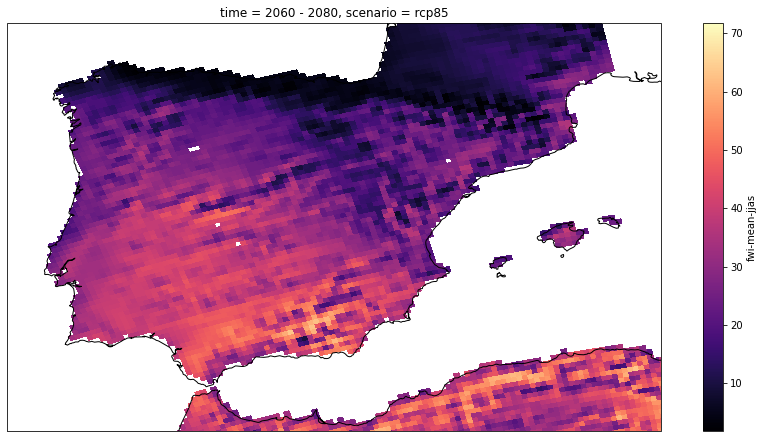

In [70]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_fire['fwi-mean-jjas'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

### Heat waves and cold spells 

**Read data** 

In [159]:
data_dir = '../../datasets/raw/climate/dataset-sis-heat-and-cold-spells/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
        ds_heat_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
        # Add scenario coordinate
        ds_heat_sce = ds_heat_sce.assign_coords({"scenario": scenario})
            
    if ns == 0:
        ds_heat = ds_heat_sce.copy()
    else:
        ds_heat = xr.concat([ds_heat, ds_heat_sce.copy()], dim='scenario')
        
#Remove variables height and quantile
ds_heat = ds_heat.drop_vars(['height', 'quantile'])
        
ds_heat

<xarray.Dataset>
Dimensions:         (lat: 425, lon: 599, time: 100, scenario: 2)
Coordinates:
  * lat             (lat) float64 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon             (lon) float64 -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time            (time) datetime64[ns] 1986-01-01 1987-01-01 ... 2085-01-01
  * scenario        (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    HWD_EU_climate  (scenario, time, lat, lon) float32 nan nan nan ... nan nan
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 11:21:55 2019
    institution:    VITO (https://vito.be/en)

**Clip area**

In [160]:
ds_heat = ds_heat.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).copy()
ds_heat

<xarray.Dataset>
Dimensions:         (lat: 78, lon: 137, time: 100, scenario: 2)
Coordinates:
  * lat             (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon             (lon) float64 -9.3 -9.2 -9.1 -9.0 -8.9 ... 4.0 4.1 4.2 4.3
  * time            (time) datetime64[ns] 1986-01-01 1987-01-01 ... 2085-01-01
  * scenario        (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    HWD_EU_climate  (scenario, time, lat, lon) float32 nan nan ... 26.48 26.35
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 11:21:55 2019
    institution:    VITO (https://vito.be/en)

**Resample time**

In [167]:
attrs = ds_heat.attrs
ds_heat = ds_heat.sel(time=slice('2000-01-01T00:00:00.000000000', '2080-01-01T00:00:00.000000000')).resample(time="20Y", label='left', loffset='10Y').mean()
ds_heat = ds_heat.assign_attrs(attrs)
ds_heat = ds_heat.sel(time=slice('2010-12-31T00:00:00.000000000', '2070-12-31T00:00:00.000000000'))
ds_heat = ds_heat.assign_coords({"time": pd.DatetimeIndex(ds_heat.time.values).year})
ds_heat = ds_heat.assign_coords({"time": np.array([f"{str(x-10)} - {str(x+10)}" for x in ds_heat.time.data])})
ds_heat

<xarray.Dataset>
Dimensions:         (time: 4, lat: 78, lon: 137, scenario: 2)
Coordinates:
  * time            (time) <U11 '2000 - 2020' '2020 - 2040' ... '2060 - 2080'
  * lat             (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon             (lon) float64 -9.3 -9.2 -9.1 -9.0 -8.9 ... 4.0 4.1 4.2 4.3
  * scenario        (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    HWD_EU_climate  (time, scenario, lat, lon) float32 nan nan ... 17.13 17.15
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 11:21:55 2019
    institution:    VITO (https://vito.be/en)

**Display data**

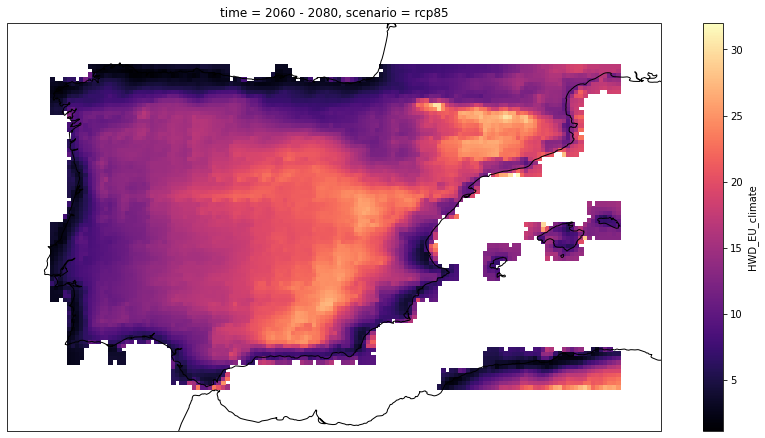

In [168]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_heat['HWD_EU_climate'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

### Temperature statistics 

**Read data** 

In [169]:
data_dir = '../../datasets/raw/climate/dataset-sis-temperature-statistics/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
        
        if n == 0:
            ds_temp_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
            
        else:
            ds = xr.open_dataset(data_dir+file, engine="netcdf4")
            # Assign new data variables to a Dataset
            ds_temp_sce = ds_temp_sce.assign({list(ds.keys())[-1]: ds[list(ds.keys())[-1]]})
            
        # Add scenario coordinate
        ds_temp_sce = ds_temp_sce.assign_coords({"scenario": scenario})
            
    if ns == 0:
        ds_temp = ds_temp_sce.copy()
    else:
        ds_temp = xr.concat([ds_temp, ds_temp_sce.copy()], dim='scenario')
        
#Remove variables height
ds_temp = ds_temp.drop_vars('height')

ds_temp

<xarray.Dataset>
Dimensions:           (time: 100, scenario: 2, lat: 425, lon: 599)
Coordinates:
  * time              (time) datetime64[ns] 1986-06-01 1987-06-01 ... 2085-06-01
  * lat               (lat) float64 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon               (lon) float64 -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * scenario          (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmax_Summer  (scenario, time, lat, lon) float32 nan nan nan ... nan nan
    mean_Tmax_Yearly  (scenario, time, lat, lon) float32 nan nan nan ... nan nan
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 21:08:09 2019
    institution:    VITO (https://vito.be/en)

**Clip area**

In [170]:
ds_temp = ds_temp.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).copy()
ds_temp

<xarray.Dataset>
Dimensions:           (time: 100, scenario: 2, lat: 78, lon: 137)
Coordinates:
  * time              (time) datetime64[ns] 1986-06-01 1987-06-01 ... 2085-06-01
  * lat               (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon               (lon) float64 -9.3 -9.2 -9.1 -9.0 -8.9 ... 4.0 4.1 4.2 4.3
  * scenario          (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmax_Summer  (scenario, time, lat, lon) float32 nan nan ... 34.28 34.24
    mean_Tmax_Yearly  (scenario, time, lat, lon) float32 nan nan nan ... nan nan
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 21:08:09 2019
    institution:    VITO (https://vito.be/en)

**Resample time**

In [171]:
attrs = ds_temp.attrs
ds_temp = ds_temp.sel(time=slice('2000-06-01T00:00:00.000000000', '2080-06-01T00:00:00.000000000')).resample(time="20Y", label='left', loffset='10Y').mean()
ds_temp = ds_temp.assign_attrs(attrs)
ds_temp = ds_temp.sel(time=slice('2010-12-31T00:00:00.000000000', '2070-12-31T00:00:00.000000000'))
ds_temp = ds_temp.assign_coords({"time": pd.DatetimeIndex(ds_temp.time.values).year})
ds_temp = ds_temp.assign_coords({"time": np.array([f"{str(x-10)} - {str(x+10)}" for x in ds_temp.time.data])})
ds_temp

<xarray.Dataset>
Dimensions:           (time: 4, scenario: 2, lat: 78, lon: 137)
Coordinates:
  * time              (time) <U11 '2000 - 2020' '2020 - 2040' ... '2060 - 2080'
  * lat               (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon               (lon) float64 -9.3 -9.2 -9.1 -9.0 -8.9 ... 4.0 4.1 4.2 4.3
  * scenario          (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmax_Summer  (time, scenario, lat, lon) float32 nan nan ... 33.26 33.22
    mean_Tmax_Yearly  (time, scenario, lat, lon) float32 nan nan nan ... nan nan
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 21:08:09 2019
    institution:    VITO (https://vito.be/en)

**Display data**

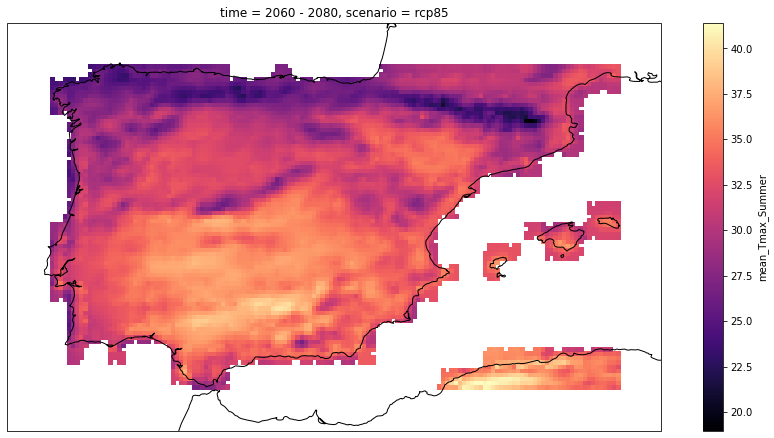

In [172]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_temp['mean_Tmax_Summer'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

### Merge Temperature statistics and Heat waves datasets

In [177]:
ds_temp_heat = ds_temp.assign(HWD_EU_climate=ds_heat.HWD_EU_climate)

### Bioclimatic indicators

Customized bioclimatic indicators were calculated on raw daily and monthly climate data timeseries per year. 
Monthly, annual and 20-year window statistics (for 1961-1980, 1981-2000, 2021-2040, 2041-2060, 2061-2080, 2081-2100) were calculated. Also median and spread (inter-quartile range) were calculated for the CMIP multi-model ensemble
for each RCP scenario.

    `1979-01-01T00:00:00.000000000` -> 1970-1989 
    `1989-01-01T00:00:00.000000000` -> 1980-1999
    `2009-01-01T00:00:00.000000000` -> 2001-2020 
    `2030-01-01T00:00:00.000000000` -> 2021-2040
    `2050-01-01T00:00:00.000000000` -> 2041-2060 
    `2070-01-01T00:00:00.000000000` -> 2061-2080
    `2090-01-01T00:00:00.000000000` -> 2081-2100
    
**Read data** 

In [124]:
data_dir = '../../datasets/raw/climate/dataset-sis-biodiversity-cmip5-regional/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    print(scenario)
    for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
        print(file)
        if n == 0:
            ds_bio_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
        else:
            if 'dry-spells_maximum-length' in file:
                # Ingest the dry spells variables as float32 and not as timedelta64
                raw = xr.open_dataset(data_dir+file, engine="netcdf4", decode_cf=False)
                del raw['dry-spells_maximum-length'].attrs['units']
                ds = xr.decode_cf(raw)
            else:
                ds = xr.open_dataset(data_dir+file, engine="netcdf4")
                
            # Assign new data variables to a Dataset
            ds_bio_sce = ds_bio_sce.assign({list(ds.keys())[-1]: ds[list(ds.keys())[-1]]})
            # Add scenario coordinate
            ds_bio_sce = ds_bio_sce.assign_coords({"scenario": scenario})
            
    if ns == 0:
        ds_bio = ds_bio_sce.copy()
    else:
        ds_bio = xr.concat([ds_bio.drop_vars('height'), ds_bio_sce.copy()], dim='scenario')

# Rename longitude/latitude to lon/lat
ds_bio = ds_bio.rename({"longitude": "lon", "latitude": "lat"})
ds_bio

rcp45
aridity_wettest-quarter_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
BIO16_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
dry-spells_maximum-length_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
BIO12_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
rcp85
BIO12_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc
aridity_wettest-quarter_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc
BIO16_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc
dry-spells_maximum-length_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc


<xarray.Dataset>
Dimensions:                    (lat: 4800, lon: 9600, time: 7, scenario: 2)
Coordinates:
  * lat                        (lat) float64 32.0 32.01 32.02 ... 71.99 72.0
  * lon                        (lon) float64 -30.0 -29.99 -29.98 ... 49.99 50.0
  * time                       (time) datetime64[ns] 1979-01-01 ... 2090-01-01
  * scenario                   (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    aridity_wettest-quarter    (scenario, time, lat, lon) float32 0.3719 ... ...
    BIO16                      (scenario, time, lat, lon) float32 4.199e-08 ....
    dry-spells_maximum-length  (scenario, time, lat, lon) float32 52.29 ... 2...
    BIO12                      (scenario, time, lat, lon) float32 2.177e-08 ....
Attributes:
    history:      Tue Dec 29 09:09:19 2020: ncpdq -a time,latitude,longitude ...
    Conventions:  CF-1.7
    Institution:  (C) VITO, Belgium
    References:   See documentation for full references at https://climate.co...
    Contact:      Please contact Copernicus User Support on the Copernicus Cl...
    Version:      v1
    Title:        C3S D427 SIS Biodiversity / Bio-climate indicators / aridit...
    Source:       CMIP5 dataset (rcp45 NorESM1-M r1i1p1) bias-adjusted to ERA...
    Licence:      ECMWF Copernicus licence 1.0

**Clip area**

In [126]:
ds_bio = ds_bio.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).copy()
ds_bio

<xarray.Dataset>
Dimensions:                    (lat: 936, lon: 1646, time: 7, scenario: 2)
Coordinates:
  * lat                        (lat) float64 35.95 35.96 35.97 ... 43.74 43.75
  * lon                        (lon) float64 -9.387 -9.379 ... 4.312 4.321
  * time                       (time) datetime64[ns] 1979-01-01 ... 2090-01-01
  * scenario                   (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    aridity_wettest-quarter    (scenario, time, lat, lon) float32 0.4548 ... ...
    BIO16                      (scenario, time, lat, lon) float32 2.795e-08 ....
    dry-spells_maximum-length  (scenario, time, lat, lon) float32 116.4 ... 44.8
    BIO12                      (scenario, time, lat, lon) float32 1.276e-08 ....
Attributes:
    history:      Tue Dec 29 09:09:19 2020: ncpdq -a time,latitude,longitude ...
    Conventions:  CF-1.7
    Institution:  (C) VITO, Belgium
    References:   See documentation for full references at https://climate.co...
    Contact:      Please contact Copernicus User Support on the Copernicus Cl...
    Version:      v1
    Title:        C3S D427 SIS Biodiversity / Bio-climate indicators / aridit...
    Source:       CMIP5 dataset (rcp45 NorESM1-M r1i1p1) bias-adjusted to ERA...
    Licence:      ECMWF Copernicus licence 1.0

**Resample time**

In [127]:
ds_bio = ds_bio.sel(time=slice('2009-01-01T00:00:00.000000000', '2070-01-01T00:00:00.000000000'))
ds_bio = ds_bio.assign_coords({"time": ds_temp.time.data})
ds_bio

<xarray.Dataset>
Dimensions:                    (lat: 936, lon: 1646, time: 4, scenario: 2)
Coordinates:
  * lat                        (lat) float64 35.95 35.96 35.97 ... 43.74 43.75
  * lon                        (lon) float64 -9.387 -9.379 ... 4.312 4.321
  * time                       (time) <U11 '2000 - 2020' ... '2060 - 2080'
  * scenario                   (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    aridity_wettest-quarter    (scenario, time, lat, lon) float32 0.483 ... 0...
    BIO16                      (scenario, time, lat, lon) float32 3.071e-08 ....
    dry-spells_maximum-length  (scenario, time, lat, lon) float32 109.3 ... 4...
    BIO12                      (scenario, time, lat, lon) float32 1.271e-08 ....
Attributes:
    history:      Tue Dec 29 09:09:19 2020: ncpdq -a time,latitude,longitude ...
    Conventions:  CF-1.7
    Institution:  (C) VITO, Belgium
    References:   See documentation for full references at https://climate.co...
    Contact:      Please contact Copernicus User Support on the Copernicus Cl...
    Version:      v1
    Title:        C3S D427 SIS Biodiversity / Bio-climate indicators / aridit...
    Source:       CMIP5 dataset (rcp45 NorESM1-M r1i1p1) bias-adjusted to ERA...
    Licence:      ECMWF Copernicus licence 1.0

**Display data**

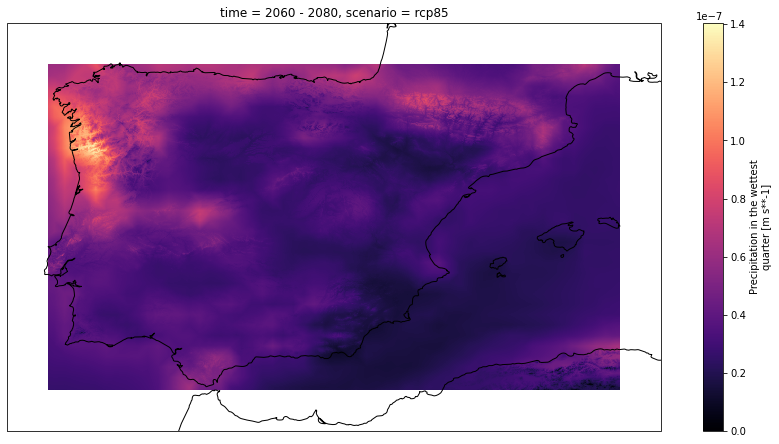

In [129]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_bio['BIO16'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

**Put all raster data together** 

In [432]:
ds_rasters = {"Fire danger indicator": ds_fire,
             "Temperature statistics and heat waves": ds_temp_heat,
             "Bioclimatic indicators": ds_bio}

## Vector data 


## Regiones geograficas (vector)
- ### Comarcas Agrarias
    **[Data source](https://www.mapa.gob.es/es/cartografia-y-sig/ide/descargas/agricultura/)**

    La distribución de la superficie de España en `Comarcas Agrarias` agrupa los territorios en unidades espaciales intermedias entre la provincia y el municipio que sin personalidad jurídico-administrativa alguna, tiene un carácter uniforme desde el punto de vista agrario.
    
- ### Municipios de España
    **[Data source](https://opendata.esri.es/datasets/53229f5912e04f1ba6dddb70a5abeb72_0/explore?location=43.017075%2C9.288571%2C5.20)**

### Comarcas Agrarias 
**Read data** 

In [94]:
comarcas_agr = gpd.read_file(f'../../datasets/raw/georegions/ComarcasAgrarias/ComarcasAgrarias.shp')

Remove Canarias, Ceuta, and Melilla

In [95]:
comarcas_agr = comarcas_agr[~comarcas_agr['DS_CCAA'].isin(['Canarias', 'Ceuta', 'Melilla'])]

**Display geometries**

<AxesSubplot:>

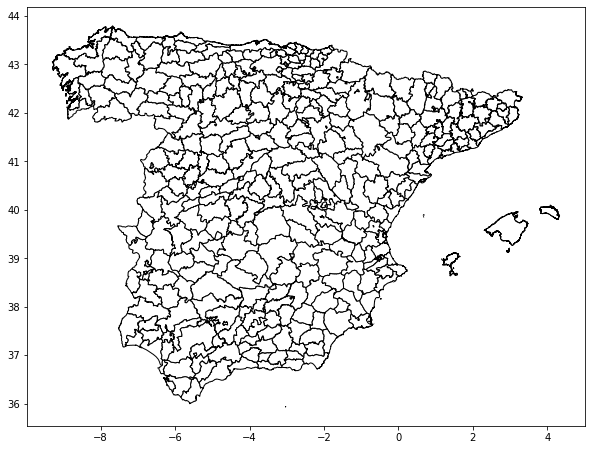

In [96]:
fig, ax = plt.subplots(figsize=(10,10))
comarcas_agr.plot(ax=ax, color='w', edgecolor='k')

### Municipios de España
**Read data** 

In [524]:
municipios = gpd.read_file(f'../../datasets/raw/georegions/Municipios/Municipios_IGN.shp')
municipios.sort_values(['CODNUT1', 'CODNUT2', 'CODNUT3', 'CODIGOINE'], inplace = True)

Remove Canarias, Ceuta, and Melilla

In [526]:
municipios = municipios[~municipios['CODNUT2'].isin(['ES70', 'ES63', 'ES64'])]

**Display geometries**

<AxesSubplot:>

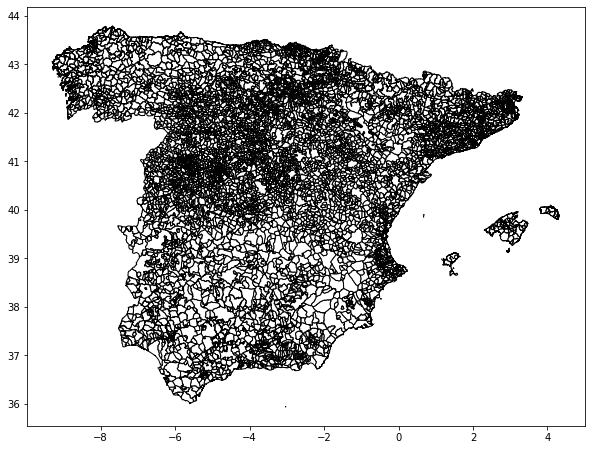

In [107]:
fig, ax = plt.subplots(figsize=(10,10))
municipios.plot(ax=ax, color='w', edgecolor='k')

**Put all vector data together** 

In [533]:
gdf_vectors = {"Comarcas agrarias": comarcas_agr,
             "Municipios": municipios}

# Zonal statistics

We convert raster data into vector by taking the mean value of each indicator at every geometry.

## Rasterize vector data
**Create the data mask by rasterizing the vector data**

In [534]:
da_masks = {}
for ds_name, ds in ds_rasters.items():
    print(ds_name)
    da_mask = {}
    for gdf_name, gdf in gdf_vectors.items():
        print(gdf_name)
        if ds_name == "Fire danger indicator":
            da_mask[gdf_name] = rasterize_vector_data(gdf.copy(), ds, name='mask', logical_coordinates=True, lon_name='lon', lat_name='lat')
        else:
            da_mask[gdf_name] = rasterize_vector_data(gdf.copy(), ds, name='mask', logical_coordinates=False, lon_name='lon', lat_name='lat')
            
    da_masks[ds_name] = da_mask      

Fire danger indicator
Comarcas agrarias
Number of indexes: 346
Number of geoms: 346
Number of ints in mask: 333
Ints not in mask: [ 97 102 104 107 119 121 123 124 195 209 210 218 243]
Adding geometries smaller than mean cell size into the mask:


100%|██████████| 13/13 [00:00<00:00, 1769.92it/s]

Municipios
Number of indexes: 8115
Number of geoms: 8115


Number of ints in mask: 2622
Ints not in mask: [   0    3    4 ... 8110 8111 8114]
Adding geometries smaller than mean cell size into the mask:


100%|██████████| 5493/5493 [00:02<00:00, 1882.09it/s]


Temperature statistics and heat waves
Comarcas agrarias
Number of indexes: 346
Number of geoms: 346
Number of ints in mask: 336
Ints not in mask: [ 97 115 119 121 123 124 195 210 218 243]
Adding geometries smaller than mean cell size into the mask:


100%|██████████| 10/10 [00:00<00:00, 3945.35it/s]

Municipios
Number of indexes: 8115
Number of geoms: 8115


Number of ints in mask: 3573
Ints not in mask: [   3    7   12 ... 8111 8113 8114]
Adding geometries smaller than mean cell size into the mask:


100%|██████████| 4542/4542 [00:00<00:00, 5015.51it/s]


Bioclimatic indicators
Comarcas agrarias
Number of indexes: 346
Number of geoms: 346
Number of ints in mask: 345
Ints not in mask: [195]
Adding geometries smaller than mean cell size into the mask:


100%|██████████| 1/1 [00:00<00:00, 1286.20it/s]

Municipios
Number of indexes: 8115
Number of geoms: 8115


Number of ints in mask: 8105
Ints not in mask: [1031 1802 2757 2759 2764 6497 6881 7018 7074 7109]
Adding geometries smaller than mean cell size into the mask:


100%|██████████| 10/10 [00:00<00:00, 3750.94it/s]


**Display mask**

**Comarcas agrarias**

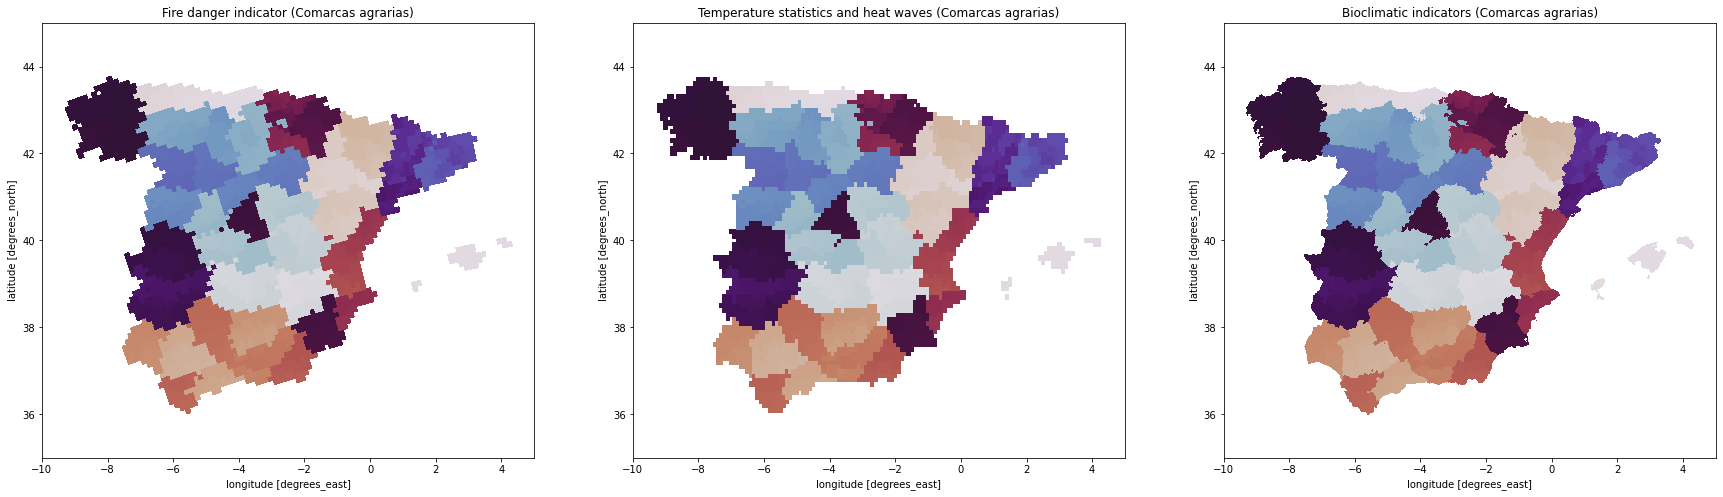

In [608]:
gdf_name = 'Comarcas agrarias'

fig, axs = plt.subplots(1, 3, figsize=(30,8))

n=0
for ds_name, masks in da_masks.items():
    mask=masks[gdf_name]
    mask.plot.pcolormesh(ax=axs[n], cmap='twilight', x='lon', y='lat', add_colorbar=False)
    axs[n].set_ylim([35, 45]);
    axs[n].set_xlim([-10, 5]);
    axs[n].set_title(f"{ds_name} ({gdf_name})");
    n+=1   

**Municipios**

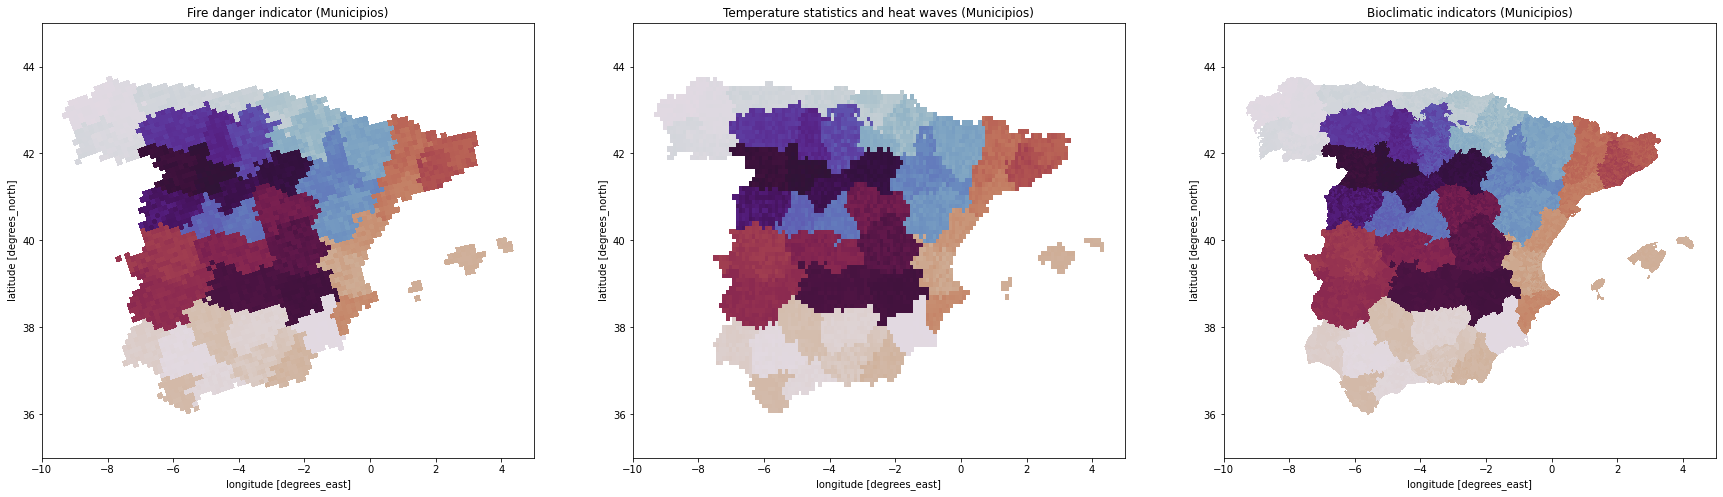

In [609]:
gdf_name = 'Municipios'

fig, axs = plt.subplots(1, 3, figsize=(30,8))

n=0
for ds_name, masks in da_masks.items():
    mask=masks[gdf_name]
    mask.plot.pcolormesh(ax=axs[n], cmap='twilight', x='lon', y='lat', add_colorbar=False)
    axs[n].set_ylim([35, 45]);
    axs[n].set_xlim([-10, 5]);
    axs[n].set_title(f"{ds_name} ({gdf_name})");
    n+=1   